In [ ]:
import pathlib
import pickle
import random
import re
import unicodedata
import numpy as np
!pip install tensorflow==2.12.0
import tensorflow as tf

# download dataset provided by Anki: https://www.manythings.org/anki/

In [ ]:
PATH = "/content/ita.txt"

In [ ]:
from Pre_processing import normalized_lines,Stat,hist

text_pairs = normalized_lines(PATH)

('lei pianse .', '[start] she cried . [end]')
('tom mangia molto .', '[start] tom eats a lot . [end]')
("l'hai fatto ?", '[start] have you done it ? [end]')
('tom dice di riuscire a prevedere il futuro .', '[start] tom says he can predict the future . [end]')
('giochiamo a baseball !', "[start] let's play baseball ! [end]")


In [ ]:
Stat()

Total Italian tokens: 29620
Total English tokens: 14903
Max Italian length: 101
Max English length: 113
377937 total pairs


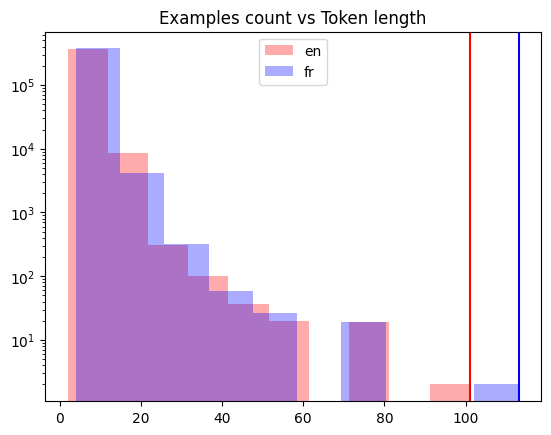

In [ ]:
hist()

# Vectorization

In [ ]:
'''
Note that the parameter max_tokens to TextVectorization object can be omitted to let the vectorizer figure it out.
But if you set them to a value smaller than the total vocabulary (such as this case),
you limit the the vectorizer to learn only the more frequent words and make the rare words as out-of-vocabulary (OOV).
'''

import pickle
import random

from tensorflow.keras.layers import TextVectorization

# Load normalized sentence pairs
with open("text_pairs.pickle", "rb") as fp:
    text_pairs = pickle.load(fp)

# train-test-val split of randomized sentence pairs
random.shuffle(text_pairs)
n_val = int(0.15*len(text_pairs))
n_train = len(text_pairs) - 2*n_val
train_pairs = text_pairs[:n_train]
val_pairs = text_pairs[n_train:n_train+n_val]
test_pairs = text_pairs[n_train+n_val:]

# Parameter determined after analyzing the input data
vocab_size_it = 20000
vocab_size_eng = 10000
seq_length = 20

# TextVectorization gives 0 for the padding
# Create vectorizer
it_vectorizer = TextVectorization(
    max_tokens=vocab_size_it,
    standardize=None,
    split="whitespace",
    output_mode="int",
    output_sequence_length=seq_length,
)
eng_vectorizer = TextVectorization(
    max_tokens=vocab_size_eng,
    standardize=None,
    split="whitespace",
    output_mode="int",
    output_sequence_length=seq_length + 1
)

# train the vectorization layer using training dataset
train_it_texts = [pair[0] for pair in train_pairs]
train_eng_texts = [pair[1] for pair in train_pairs]
it_vectorizer.adapt(train_it_texts)
eng_vectorizer.adapt(train_eng_texts)

# save for subsequent steps
with open("vectorize.pickle", "wb") as fp:
    data = {
        "train": train_pairs,
        "val":   val_pairs,
        "test":  test_pairs,
        "itvec_config":  it_vectorizer.get_config(),
        "itvec_weights": it_vectorizer.get_weights(),
        "engvec_config":  eng_vectorizer.get_config(),
        "engvec_weights": eng_vectorizer.get_weights(),
    }
    pickle.dump(data, fp)

In [ ]:
## Some tests:
example_sentences = [
    "[start] she didn't tolerate his selfishness . [end]",
    "[start] astrubale ! [end]"
]

for ex in example_sentences:
    print(eng_vectorizer(ex))

tf.Tensor(
[   2   51   48 3020   44 4792    4    3    0    0    0    0    0    0
    0    0    0    0    0    0    0], shape=(21,), dtype=int64)
tf.Tensor(
[  2   1 182   3   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0], shape=(21,), dtype=int64)


In [ ]:
from tensorflow.keras.layers import TextVectorization

# load text data and vectorizer weights
with open("vectorize.pickle", "rb") as fp:
    data = pickle.load(fp)

train_pairs = data["train"]
val_pairs = data["val"]
test_pairs = data["test"]   # not used

it_vectorizer = TextVectorization.from_config(data["itvec_config"])
it_vectorizer.set_weights(data["itvec_weights"])
eng_vectorizer = TextVectorization.from_config(data["engvec_config"])
eng_vectorizer.set_weights(data["engvec_weights"])

In [ ]:
# set up Dataset object
def format_dataset(it, eng):
    """Take an italian and a eng sentence pair, convert into input and target.
    The input is a dict with keys `encoder_inputs` and `decoder_inputs`, each
    is a vector, corresponding to italian and english sentences respectively.
    The target is also vector of the english sentence, advanced by 1 token. All
    vector are in the same length.
    """
    it = it_vectorizer(it)
    eng = eng_vectorizer(eng)

    source = {"encoder_inputs": it,
              "decoder_inputs": eng[:, :-1]} # removing the end tag
    target = eng[:, 1:] # removing the start tag
    return (source, target)

def make_dataset(pairs, batch_size=64):
    """Create TensorFlow Dataset for the sentence pairs"""
    # aggregate sentences using zip(*pairs) basically putting all the first elements togheter and all the second elements toghether
    it_texts, eng_texts = zip(*pairs)
    # convert them into list, and then create tensors
    dataset = tf.data.Dataset.from_tensor_slices((list(it_texts), list(eng_texts)))
    return dataset.shuffle(2048) \
                  .batch(batch_size).map(format_dataset) \
                  .prefetch(16).cache()

train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)


In [ ]:
# test the dataset
for inputs, targets in train_ds.take(1):
    print(f'inputs["encoder_inputs"].shape: {inputs["encoder_inputs"].shape}')
    print(f'inputs["encoder_inputs"][0]: {inputs["encoder_inputs"][0]}')
    print(f'inputs["decoder_inputs"].shape: {inputs["decoder_inputs"].shape}')
    print(f'inputs["decoder_inputs"][0]: {inputs["decoder_inputs"][0]}')
    print(f"targets.shape: {targets.shape}")
    print(f"targets[0]: {targets[0]}")

inputs["encoder_inputs"].shape: (64, 20)
inputs["encoder_inputs"][0]: [ 12  15 167  92 471 652   2   0   0   0   0   0   0   0   0   0   0   0
   0   0]
inputs["decoder_inputs"].shape: (64, 20)
inputs["decoder_inputs"][0]: [  2  21  84  23  27 548   4   3   0   0   0   0   0   0   0   0   0   0
   0   0]
targets.shape: (64, 20)
targets[0]: [ 21  84  23  27 548   4   3   0   0   0   0   0   0   0   0   0   0   0
   0   0]


In [ ]:
from CustomSchedule import CustomSchedule

key_dim = 128
lr = CustomSchedule(key_dim)
optimizer = tf.keras.optimizers.legacy.Adam(lr, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

In [ ]:
from transformer import transformer, masked_loss, masked_accuracy


vocab_size_it = 20000
vocab_size_eng = 10000
seq_len = 20
num_layers = 4
num_heads = 8
key_dim = 128
ff_dim = 512
dropout = 0.1


model = transformer(num_layers, num_heads, seq_len, key_dim, ff_dim,
                    vocab_size_it, vocab_size_eng, dropout)
lr = CustomSchedule(key_dim)

optimizer = tf.keras.optimizers.Adam(lr, beta_1=0.9, beta_2=0.98, epsilon=1e-9)
model.compile(loss=masked_loss, optimizer=optimizer, metrics=[masked_accuracy])
model.summary()

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, 20)]         0           []                               
                                                                                                  
 embed_enc (PositionalEmbedding  (None, 20, 128)     2560000     ['encoder_inputs[0][0]']         
 )                                                                                                
                                                                                                  
 enc0 (Sequential)              (None, 20, 128)      659712      ['embed_enc[0][0]']              
                                                                                                  
 enc1 (Sequential)              (None, 20, 128)      659712      ['enc0[0][0]']         

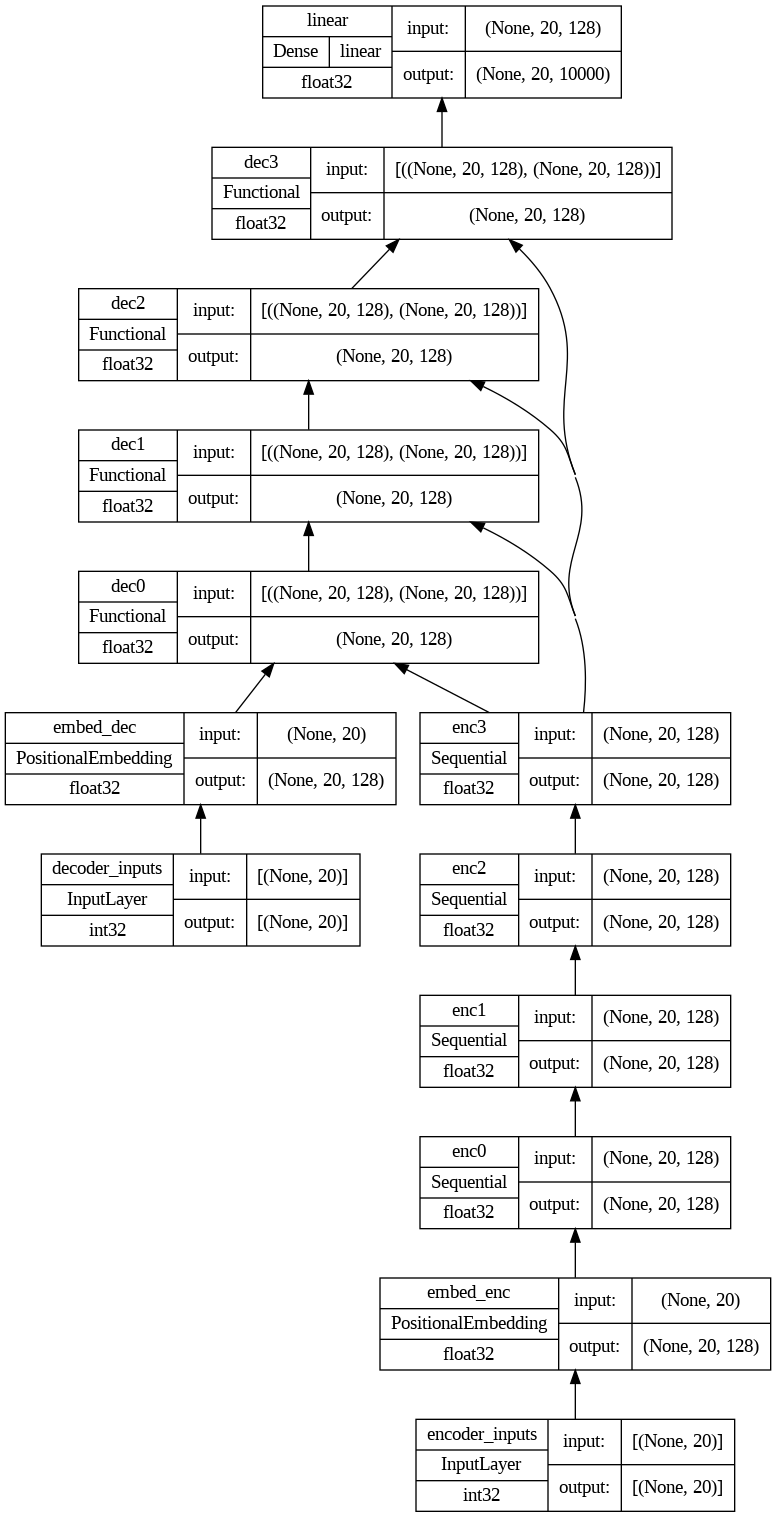

In [ ]:
tf.keras.utils.plot_model(model, "transformer.png",
                          show_shapes=True, show_dtype=True, show_layer_names=True,
                          rankdir='BT', show_layer_activations=True)

In [ ]:
model.compile(loss=masked_loss, optimizer=optimizer, metrics=[masked_accuracy])
#model.summary()
model.fit(train_ds,
                epochs=30,
                validation_data=val_ds)

In [23]:
model.save("transformer_weights_it-eng.h5")

In [22]:
model

In [41]:
# training parameters used
seq_len = 20
vocab_size_it = 20000
vocab_size_eng = 10000

def translate(sentence):
    """Create the translated sentence"""
    enc_tokens = it_vectorizer([sentence])
    lookup = list(eng_vectorizer.get_vocabulary())
    start_sentinel, end_sentinel = "[start]", "[end]"
    output_sentence = [start_sentinel]
    # generate the translated sentence word by word
    for i in range(seq_len):
        vector = eng_vectorizer([" ".join(output_sentence)])
        assert vector.shape == (1, seq_len+1)
        dec_tokens = vector[:, :-1]
        assert dec_tokens.shape == (1, seq_len)
        pred = model([enc_tokens, dec_tokens])
        # this is the next word
        assert pred.shape == (1, seq_len, vocab_size_eng)
        word = lookup[np.argmax(pred[0, i, :])]
        output_sentence.append(word)
        if word == end_sentinel:
            break
    return output_sentence



sentence = "ciao io sono bellissimo ."
res = translate(sentence)
print(res)

sentence = "ciao io sono simone ."
res = translate(sentence)
print(res)

sentence = "quando sei stata al mare ?"
res = translate(sentence)
print(res)

sentence = "Quando sei stata al mare ?"
res = translate(sentence)
print(res)

sentence = "la penna è stata comprata dal dottore ."
res = translate(sentence)
print(res)

sentence = "se avessi vinto alla lotteria , sarei molto felice ."
res = translate(sentence)
print(res)


['[start]', 'hi', "i'm", 'beautiful', '.', '[end]']
['[start]', 'hi', "i'm", '[UNK]', '.', '[end]']
['[start]', 'when', 'have', 'you', 'been', 'to', 'the', 'sea', '?', '[end]']
['[start]', 'have', 'you', 'been', 'at', 'the', 'sea', '?', '[end]']
['[start]', 'the', 'pen', 'has', 'been', 'bought', 'by', 'the', 'doctor', '.', '[end]']
['[start]', 'if', 'i', 'had', 'won', 'the', 'lottery', ',', "i'd", 'be', 'very', 'happy', '.', '[end]']


Some remarks:
- this was trained for 12 epochs due to the time consuming operations
- Obviously to improve the performances we can train longer
- instead of training my own embedding is possible to use pre-trained to provide higher quality
- tuning the hyperparameters is another strategy
- if we want good results we need to respect the preprocessing done (always finish with a ". , ? !")